In [47]:
!pip install scipy

In [37]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

In [38]:
#portfolio composition
ticker_list = ['AAPL','AMZN','GOOGL','MSFT','TSLA']
data = yf.download(ticker_list, start="2015-01-01", end="2025-01-01", auto_adjust=False)


[*********************100%***********************]  5 of 5 completed


In [39]:
adj_close_prices = data['Adj Close']
r = adj_close_prices.pct_change().dropna()
r

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2015-01-05,-0.028172,-0.020517,-0.019054,-0.009196,-0.042041
2015-01-06,0.000094,-0.022833,-0.024680,-0.014678,0.005664
2015-01-07,0.014022,0.010600,-0.002941,0.012705,-0.001562
2015-01-08,0.038422,0.006836,0.003484,0.029419,-0.001564
2015-01-09,0.001073,-0.011749,-0.012211,-0.008405,-0.018802
...,...,...,...,...,...
2024-12-24,0.011478,0.017729,0.007604,0.009374,0.073572
2024-12-26,0.003176,-0.008732,-0.002601,-0.002777,-0.017630
2024-12-27,-0.013242,-0.014534,-0.014519,-0.017302,-0.049479


In [51]:
def dirichlet_weight_simulator(portfolio_asset,n_simulations=1, alpha=1):
    """
    :alpha: determines level of diversification
    alpha = 1.0: Uniformly distributed across the simplex (balanced)
    alpha < 1.0: Concentrated portfolios (fewer assets with high weights)
    alpha > 1.0: Highly diversified portfolios (weights closer to 1/N)
    """
    n = portfolio_asset.shape[1]
    alpha = np.ones(n) * 0.1 

    #simulation
    simulated_weights = np.random.default_rng().dirichlet(alpha, size=n_simulations)
    assert np.isclose(np.sum(simulated_weights,axis =1),1).all()
    return simulated_weights
    

In [42]:
#portfolio returns
np.random.seed(183183)
w = dirichlet_weight_simulator(r)[0]
r_port = r @ w.T
r_port

Date
2015-01-05   -0.037687
2015-01-06    0.000311
2015-01-07    0.000881
2015-01-08    0.001169
2015-01-09   -0.016902
                ...   
2024-12-24    0.061323
2024-12-26   -0.015246
2024-12-27   -0.042015
2024-12-30   -0.028343
2024-12-31   -0.027415
Length: 2515, dtype: float64

In [43]:
#portfolio standard deviation
port_var = w.T @r.cov() @ w
port_std = np.sqrt(port_var)

#portfolio varince and standard deviation via covariance matrix decomposition
#
D = np.diag(r.std())
R = r.corr()
port_var_d = w.T @D@R@D @ w

print(f'Portfolio Variance: {port_var}')
print(f'Portfolio decomposed: {port_var_d}')
#since stocks covarinace can be decomposed as cov_matrix = D @ R @ D it means that portfolio variance is a
#function of weights, indiviadual standard deviation and the correlation matrix. Let's first explore 
# the influence individual standard deviations have on portfolio variance.

Portfolio Variance: 0.0009136694163137665
Portfolio decomposed: 0.0009136694163137664


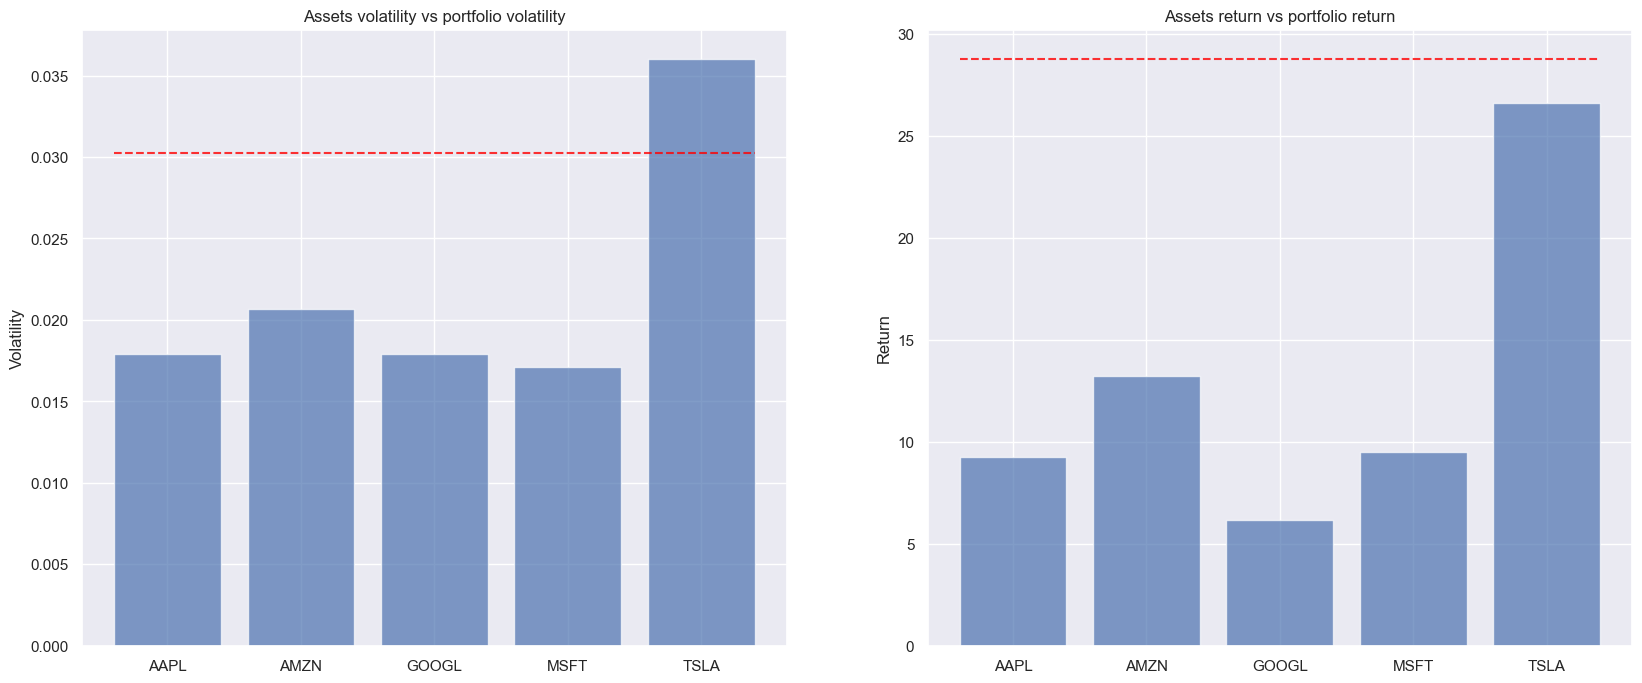

In [44]:
#Lets visualise assets' standard deviation and returns vs portfolio
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 8))

ax1.bar(x=r.columns,height = r.std(), alpha = 0.7)
ax1.hlines(y = port_std, xmin=-0.4,xmax=4.4,linestyle = '--', color = 'red', alpha = 0.8, label = 'portfolio std')
ax1.set_title('Assets volatility vs portfolio volatility')
ax1.set_ylabel('Volatility')
ax1.legend

ax2.bar(x= r.columns,height = (r+1).prod()-1, alpha = 0.7)
ax2.hlines(y = (1+r_port).prod()-1, xmin=-0.4,xmax=4.4,linestyle = '--', color = 'red', alpha = 0.8, label = 'portfolio std')
ax2.set_title('Assets return vs portfolio return')
ax2.set_ylabel('Return')
ax2.legend

plt.show()

In [45]:
#exploring  the relationship between portfolio varinace and individual asset variance
multipliers = np.linspace(0.1,5, 500)
portfolio_var = []
tsla_var= []

for i in multipliers:
    temp_returns = r * np.array([1,1,1,1,i])
    temp_port_variances = w.T @ temp_returns.cov() @ w
    tsla_var.append(temp_returns['TSLA'].var())
    portfolio_var.append(temp_port_variances)
    assert np.allclose(r.corr(), temp_returns.corr())

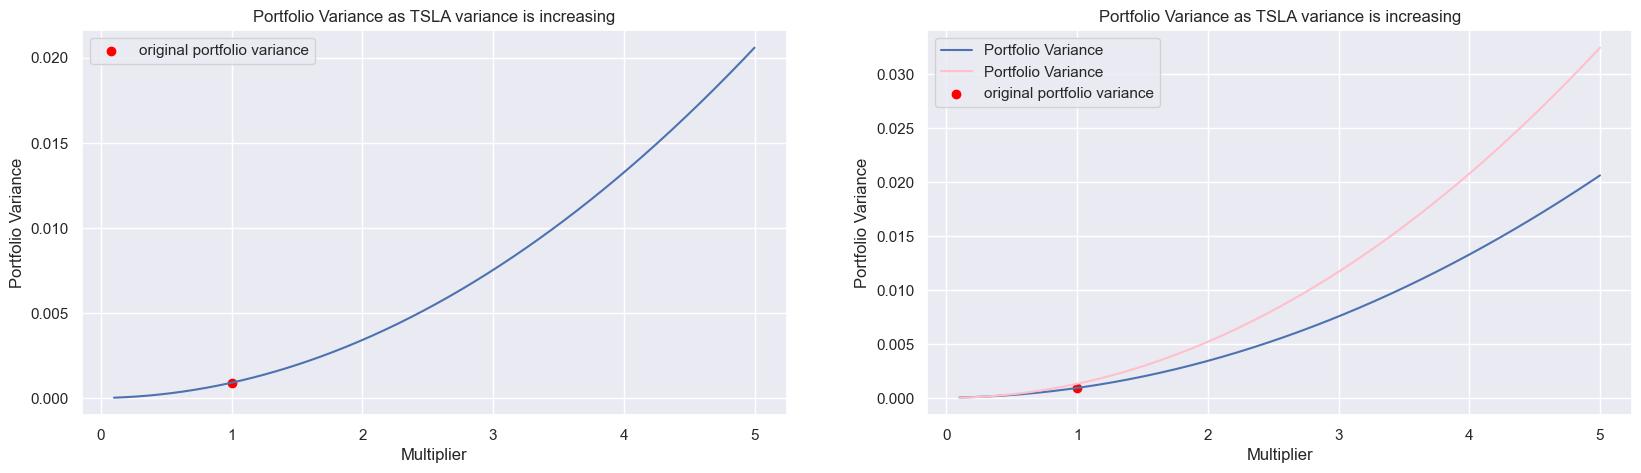

In [46]:
#plots
fig, (ax1,ax2) = plt.subplots(1,2,figsize= (20,5))

ax1.plot(multipliers, portfolio_var)
ax1.scatter(1,port_var, color = 'red', label = 'original portfolio variance' )
ax1.set_title('Portfolio Variance as TSLA variance is increasing')
ax1.set_xlabel('Multiplier')
ax1.set_ylabel('Portfolio Variance')
ax1.legend()

ax2.plot(multipliers, portfolio_var, label = 'Portfolio Variance')
ax2.plot(multipliers, tsla_var, color = 'pink', label = 'Portfolio Variance')
ax2.scatter(1,port_var, color = 'red', label = 'original portfolio variance' )
ax2.set_title('Portfolio Variance as TSLA variance is increasing')
ax2.set_xlabel('Multiplier')
ax2.set_ylabel('Portfolio Variance')
ax2.legend()

Text(0, 0.5, 'Portfolio Variance')

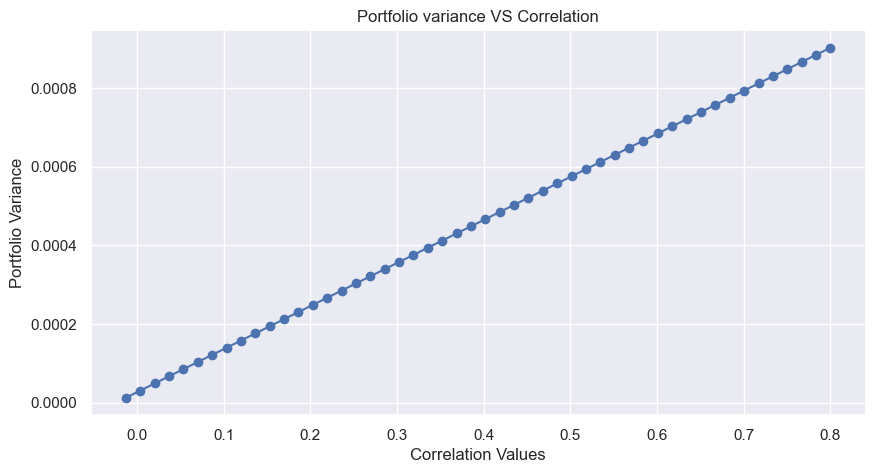

In [10]:
#exploring correlation matrix
np.random.seed(183183)
n_assets = 80
w = np.random.dirichlet(np.ones(n_assets), size = 1)[0]

degrees_of_freedom = 8 
variances = np.random.chisquare(df=degrees_of_freedom, size = n_assets)
variances = variances/np.max(variances) *0.003
std_devs = np.sqrt(variances)
D = np.diag(std_devs)

#correlation values
correlation_values = np.linspace(-1/(n_assets-1), 0.8, 50)

correlation_matrix = []
portfolio_variances = []

for i in correlation_values:
    R = np.full((n_assets,n_assets), i)
    np.fill_diagonal(R,1)
    correlation_matrix.append(R)
    #portfolio variances
    portfolio_var = w.T @ D @ R @ D @ w
    portfolio_variances.append(portfolio_var)

fig, ax = plt.subplots(figsize= (10,5))
ax.plot(correlation_values,portfolio_variances,'b-o')
ax.set_title('Portfolio variance VS Correlation')
ax.set_xlabel('Correlation Values')
ax.set_ylabel('Portfolio Variance')

/var/folders/lj/j4hv7vps62b2bd_32mntq75r0000gn/T/ipykernel_51966/2928745136.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_ret = expected_returns[max_ret_idx]


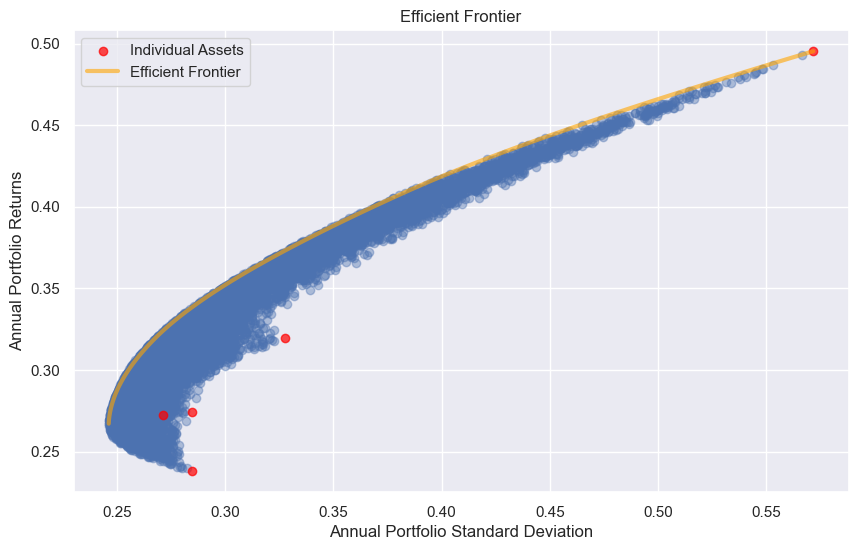

In [73]:
from scipy.optimize import minimize

weights = dirichlet_weight_simulator(r,n_simulations=20000, alpha=0.7)

#initialising variables
eff_front_dict = {}
cov_matrix_ret = r.cov()*252
expected_returns = r.mean()*252

#filling efficient frontier dict
for w in weights:
    r_port = expected_returns @ w.T
    port_std = np.sqrt(w.T @ cov_matrix_ret @ w)
    eff_front_dict[str(list(w))] = [r_port,port_std]
eff_front_dataframe = pd.DataFrame(eff_front_dict, index = ['Returns', 'Standard Deviation']).T

def get_portfolio_stats(weights,expected_returns,cov_matrix):
    port_ret = expected_returns@weights
    port_std = np.sqrt(weights.T @ cov_matrix @ weights)
    return port_ret, port_std

def negative_sharpe_ratio(weights, expected_returns,cov_matrix, risk_free = 0.02):
    port_ret, port_std = get_portfolio_stats(weights,expected_returns,cov_matrix)
    sharpe_ratio = (port_ret- risk_free)/port_std
    return -sharpe_ratio

def minumun_varinace(weights, expected_returns, cov_matrix):
    return get_portfolio_stats(weights,expected_returns,cov_matrix)[1]


def efficient_frontier_point(expected_returns, cov_matrix, target_return):
    n_assets = len(expected_returns)
    args = (expected_returns, cov_matrix)
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: get_portfolio_stats(w, expected_returns, cov_matrix)[0] - target_return}
    )
    bounds = tuple((0, 1) for _ in range(n_assets))

    result = minimize(
        minimum_variance,
        x0=np.ones(n_assets) / n_assets,
        args=args,
        method='SLSQP',
        bounds=bounds,
        
        constraints=constraints
    )

    return result.x

def get_efficient_frontier(expected_returns, cov_matrix, n_points=100):
    # Find the minimum variance portfolio
    n_assets = len(expected_returns)
    args = (expected_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(n_assets))

    min_var_result = minimize(
        minimum_variance,
        x0=np.ones(n_assets) / n_assets,
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    min_ret, min_std = get_portfolio_stats(min_var_result.x, expected_returns, cov_matrix)

    # Find the maximum return portfolio
    max_ret_idx = np.argmax(expected_returns)
    max_ret = expected_returns[max_ret_idx]

    # Generate points on the efficient frontier
    target_returns = np.linspace(min_ret, max_ret, n_points)
    efficient_portfolios = []

    for target_return in target_returns:
        weights = efficient_frontier_point(expected_returns, cov_matrix, target_return)
        ret, std = get_portfolio_stats(weights, expected_returns, cov_matrix)
        efficient_portfolios.append([std, ret])

    return np.array(efficient_portfolios)


# Calculate the efficient frontier points
efficient_points = get_efficient_frontier(expected_returns, cov_matrix_ret)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(x=eff_frontier_dataframe['Standard Deviation'],
           y=eff_frontier_dataframe['Returns'],
           alpha=0.4)
plt.scatter(x=r.std() * np.sqrt(252),
           y=expected_returns,
           color='red',
           label="Individual Assets",
           alpha=0.7)
plt.plot(efficient_points[:,0],
         efficient_points[:,1],
         'orange',
         linewidth=3,
         label='Efficient Frontier',
         alpha=0.6)
plt.title("Efficient Frontier")
plt.xlabel("Annual Portfolio Standard Deviation")
plt.ylabel("Annual Portfolio Returns")
plt.legend()
plt.grid(True)
plt.show()

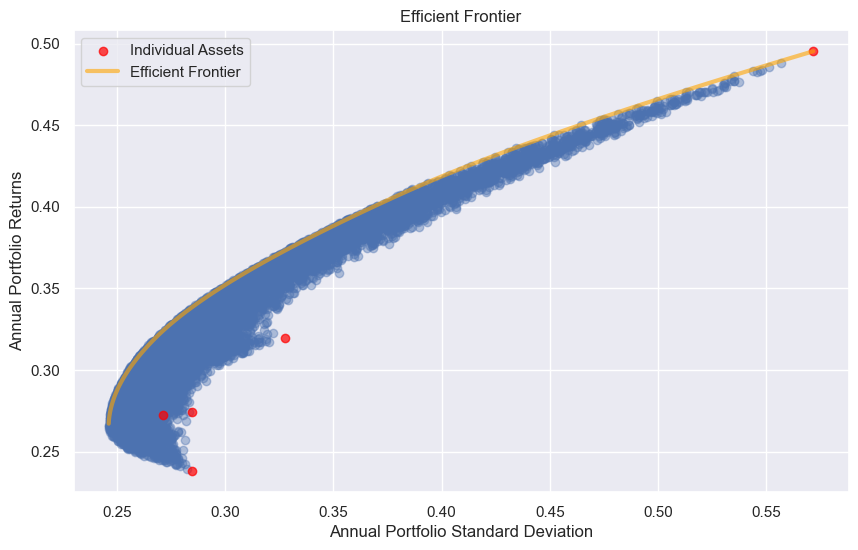

In [78]:
from scipy.optimize import minimize

weights = np.random.dirichlet(np.ones(5)*0.7, size = 20000) # Creating 20000 sets of weights using dirichlet distribution

assert np.isclose(np.sum(weights, axis = 1), 1).all() # Check that each set of weights sum up to 1

eff_front_dict = {}
cov_matrix_ret = r.cov() * 252
expected_returns = r.mean() * 252


# Filling the eff_front_dict
for w in weights:
  port_ret = expected_returns @ w.T # Annualized percent returns as expected returns
  port_std = np.sqrt(w.T @ cov_matrix_ret @ w)
  eff_front_dict[str(list(w))] = [port_ret, port_std]

eff_frontier_dataframe = pd.DataFrame(eff_front_dict, index = ['Returns', 'Standard Deviation']).T # Storing everything in one dataframe

def get_portfolio_stats(weights, expected_returns, cov_matrix):
    port_ret = expected_returns @ weights
    port_std = np.sqrt(weights.T @ cov_matrix @ weights)
    return port_ret, port_std

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.02):
    port_ret, port_std = get_portfolio_stats(weights, expected_returns, cov_matrix)
    sharpe_ratio = (port_ret - risk_free_rate) / port_std
    return -sharpe_ratio

def minimum_variance(weights, expected_returns, cov_matrix):
    return get_portfolio_stats(weights, expected_returns, cov_matrix)[1]

def efficient_frontier_point(expected_returns, cov_matrix, target_return):
    n_assets = len(expected_returns)
    def objective(weights):
       return minimum_variance(weights, expected_returns, cov_matrix)
    args = (expected_returns, cov_matrix)#when using the fuction without specifying the objective
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: get_portfolio_stats(w, expected_returns, cov_matrix)[0] - target_return}
    )
    bounds = tuple((0, 1) for _ in range(n_assets))

    result = minimize(
        objective,
        x0=np.ones(n_assets) / n_assets,
      #  args=args,
        method='SLSQP',
        bounds=bounds,
        
        constraints=constraints
    )

    return result.x

def get_efficient_frontier(expected_returns, cov_matrix, n_points=100):
    # Find the minimum variance portfolio
    n_assets = len(expected_returns)
    args = (expected_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(n_assets))

    min_var_result = minimize(
        minimum_variance,
        x0=np.ones(n_assets) / n_assets,
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    min_ret, min_std = get_portfolio_stats(min_var_result.x, expected_returns, cov_matrix)

    # Find the maximum return portfolio
    max_ret_idx = np.argmax(expected_returns)
    max_ret = expected_returns.iloc[max_ret_idx]

    # Generate points on the efficient frontier
    target_returns = np.linspace(min_ret, max_ret, n_points)
    efficient_portfolios = []

    for target_return in target_returns:
        weights = efficient_frontier_point(expected_returns, cov_matrix, target_return)
        ret, std = get_portfolio_stats(weights, expected_returns, cov_matrix)
        efficient_portfolios.append([std, ret])

    return np.array(efficient_portfolios)

# Calculate the efficient frontier points
efficient_points = get_efficient_frontier(expected_returns, cov_matrix_ret)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(x=eff_frontier_dataframe['Standard Deviation'],
           y=eff_frontier_dataframe['Returns'],
           alpha=0.4)
plt.scatter(x=r.std() * np.sqrt(252),
           y=expected_returns,
           color='red',
           label="Individual Assets",
           alpha=0.7)
plt.plot(efficient_points[:,0],
         efficient_points[:,1],
         'orange',
         linewidth=3,
         label='Efficient Frontier',
         alpha=0.6)
plt.title("Efficient Frontier")
plt.xlabel("Annual Portfolio Standard Deviation")
plt.ylabel("Annual Portfolio Returns")
plt.legend()
plt.grid(True)
plt.show()